# Eczamine Deep Learning Model (EczaNet)

In [17]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [18]:
#hide
from fastbook import *
from fastai.vision.widgets import *
from time import sleep

<br><br><br><br>
Using Microsoft Cognitive Services we can use Bing Image Search.
Once you've set `key`, you can use `search_images_bing`.

In [19]:
key = os.environ.get('AZURE_SEARCH_KEY', 'b9117fd6254c4253bc7f47c64cb8947a')


<br><br><br><br>
The URLs of 150 grizzly bears (or, at least, images that Bing Image Search finds for that search term). Let's look at one...

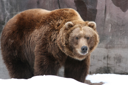

In [20]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('content_url')

dest = 'images/grizzly.jpg' #make `images` dir exists
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

<br><br><br><br>
Download 150 datapoints (images) for each class and put them into classes/class1, classes/class2, etc.

In [21]:
classes = 'grizzly','black'
path = Path('bears')

# May cause ERROR - `BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.` caused by trying to multithread
if not path.exists():
    path.mkdir()
    for c in classes:
        dest = (path/c)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{c} bear')
        download_images(dest, urls=results.attrgot('content_url'))
        sleep(3) # 10 second to not overload cognitive services

# c = classes[1]
# dest = (path/c)
# results = search_images_bing(key, f'{c} bear')
# download_images(dest, urls=results.attrgot('content_url'))

In [22]:
# To remove all the failed images, you can use `unlink` (delete) on each of them.
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink);

Exception in thread QueueManagerThread:
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\envs\sak\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Miniconda3\envs\sak\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\ProgramData\Miniconda3\envs\sak\lib\concurrent\futures\process.py", line 394, in _queue_management_worker
    work_item.future.set_exception(bpe)
  File "C:\ProgramData\Miniconda3\envs\sak\lib\concurrent\futures\_base.py", line 539, in set_exception
    raise InvalidStateError('{}: {!r}'.format(self._state, self))
concurrent.futures._base.InvalidStateError: CANCELLED: <Future at 0x1d7ab4ea520 state=cancelled>


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

<br><br><br><br>
Create `Dataloader` to serve data using `DataBlock`

In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),              # image -> category
    get_items=get_image_files,                       # takes path, returns list of all images in that path (recursively)
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # 20% of dataset used for validation
    get_y=parent_label,                              # use parent folder as label for class
    item_tfms=Resize(128))                           # resize all images to 128 by 128

dls = bears.dataloaders(path)

In [ ]:
# Let's have a look at the RandomResizedCrop batch
bears = bears.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

<br><br><br><br>
Train model using trasnfer learning and resnet18 as base

In [ ]:
# tranfer learning using cnn and resnet18 with a batchsize=4 
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

In [ ]:
# view confusion matrix (contingency table / cross tabulation)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
# the 5 worst predictions by the model
interp.plot_top_losses(5, nrows=1)

`ImageClassifierCleaner` allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling

In [ ]:
# remove / relabel highest-loss images using a GUI
cleaner = ImageClassifierCleaner(learn)
cleaner